In [156]:
# %load_ext rpy2.ipython 
# import vamb
%config IPCompleter.greedy=True
%config Completer.use_jedi = True
# %load_ext rpy2.ipython
%matplotlib inline


In [162]:
import pickle
import numpy as np
import pandas as pd
import os
import glob
import requests
import xmltodict
import json
from itertools import compress
import re
import seaborn as sns
import matplotlib as plt
plt.rcParams['figure.figsize'] = [10, 5]

In [4]:
%cd /home/gladkov2/storage/metagenome/rnf_c_new/
!ls -halt

/mnt/storage/metagenome/rnf_c_new
total 12K
drwxrwxr-x 3 gladkov2 gladkov2 4.0K Aug 13 08:25 .
drwxrwxr-x 2 gladkov2 gladkov2 4.0K Aug 12 00:43 anno
drwxrwxrwx 9 root     root     4.0K Aug  2 09:25 ..


In [5]:
os.getcwd()

'/mnt/storage/metagenome/rnf_c_new'

In [6]:
files = sorted(glob.glob(f"{os.getcwd()}/anno/*.emapper.annotations"))
names = [os.path.basename(i).split(".")[0] for i in files]
file_list = list(zip(names, files))
header = pd.read_csv(file_list[1][1],sep="\t", skiprows=4 ,nrows=0).columns.to_list()
dfs = [pd.read_csv(f[1], sep="\t", comment="#", header=None, names=header).assign(site=f[0]) for f in file_list]
df = pd.concat(dfs, ignore_index=True)

In [175]:
df.columns

Index(['#query', 'seed_ortholog', 'evalue', 'score', 'eggNOG_OGs',
       'max_annot_lvl', 'COG_category', 'Description', 'Preferred_name', 'GOs',
       'EC', 'KEGG_ko', 'KEGG_Pathway', 'KEGG_Module', 'KEGG_Reaction',
       'KEGG_rclass', 'BRITE', 'KEGG_TC', 'CAZy', 'BiGG_Reaction', 'PFAMs',
       'site'],
      dtype='object')

In [180]:
pd.set_option('display.max_columns', None)
df.head()

,#query,seed_ortholog,evalue,score,eggNOG_OGs,max_annot_lvl,COG_category,Description,Preferred_name,GOs,EC,KEGG_ko,KEGG_Pathway,KEGG_Module,KEGG_Reaction,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG_Reaction,PFAMs,site
0,contig_1_0,700598.Niako_5238,0.000000e+00,1404.0,"COG1629@1|root,COG1629@2|Bacteria,4NDXS@976|Ba...",976|Bacteroidetes,P,CarboxypepD_reg-like domain,-,-,-,-,-,-,-,-,-,-,-,-,"CarbopepD_reg_2,Plug,TonB_dep_Rec",C1
1,contig_1_3,700598.Niako_5237,4.340000e-255,790.0,"COG1435@1|root,COG1435@2|Bacteria,4NHCM@976|Ba...",976|Bacteroidetes,F,SusD family,-,-,-,ko:K21572,-,-,-,-,"ko00000,ko02000","8.A.46.1,8.A.46.3",-,-,"SusD-like_3,SusD_RagB",C1
2,contig_1_6,700598.Niako_5236,3.420000e-155,503.0,"28IBC@1|root,2Z8DV@2|Bacteria,4NQRQ@976|Bacter...",976|Bacteroidetes,S,Domain of unknown function (DUF5018),-,-,-,-,-,-,-,-,-,-,-,-,DUF5018,C1
3,contig_1_5,700598.Niako_5235,2.440000e-198,623.0,"COG1649@1|root,COG1649@2|Bacteria,4PHU5@976|Ba...",976|Bacteroidetes,S,Domain of unknown function,-,-,-,-,-,-,-,-,-,-,-,-,"DUF4985,GHL10",C1
4,contig_1_8,714943.Mucpa_2717,3.390000e-110,364.0,"COG4632@1|root,COG4632@2|Bacteria,4NR1M@976|Ba...",976|Bacteroidetes,G,COGs COG4632 Exopolysaccharide biosynthesis pr...,-,-,-,-,-,-,-,-,-,-,-,-,"Metallophos,NAGPA,fn3",C1


In [7]:
df = df.replace('-', np.nan)

In [205]:
(df.count() / df.count()[0] * 100).round()

#query            100.0
seed_ortholog     100.0
evalue            100.0
score             100.0
eggNOG_OGs        100.0
max_annot_lvl     100.0
COG_category       93.0
Description        93.0
Preferred_name     31.0
GOs                 8.0
EC                 26.0
KEGG_ko            51.0
KEGG_Pathway       30.0
KEGG_Module        20.0
KEGG_Reaction      20.0
KEGG_rclass        20.0
BRITE              51.0
KEGG_TC            11.0
CAZy                1.0
BiGG_Reaction       1.0
PFAMs              91.0
site              100.0
dtype: float64

In [262]:
mask = df.head(1000).Description.str.contains("ATPase", na=False)
mask

0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996     True
997    False
998     True
999    False
Name: Description, Length: 1000, dtype: bool

In [370]:
df.shape[0]

7243957

In [366]:
df_cat = df[df.Description.str.contains("catalase", na=False)]

In [376]:
df_cat.groupby("KEGG_ko").count()["#query"].sort_values(ascending=False)

KEGG_ko
ko:K03782    1103
ko:K07217     412
ko:K03781     191
ko:K06334      32
Name: #query, dtype: int64

amazings re for and -- save for great future ```r'^(?=.*K03781)(?=.*K19885)'```

"1.11.1.6" -- for catalases -- that means ko ko:K03781,ko:K05520

In [129]:
df['id'] = df['site'] + "_" + df['#query'] 

In [130]:
df_cat_ko = df[df.KEGG_ko.str.contains("K03781|K19885", na=False)]

In [9]:
df_cat_ko.groupby("Description").count()["#query"].sort_values(ascending=False)

Description
Serves to protect cells from the toxic effects of hydrogen peroxide                                                             690
Catalase                                                                                                                        311
serves to protect cells from the toxic effects of hydrogen peroxide                                                             250
Belongs to the catalase family                                                                                                  178
Has an organic peroxide-dependent peroxidase activity                                                                           162
PFAM Catalase domain protein                                                                                                     22
Occurs in almost all aerobically respiring organisms and serves to protect cells from the toxic effects of hydrogen peroxide     18
COG0753 Catalase                                                

In [10]:
df_cat_ko.groupby("KEGG_ko").count()["#query"].sort_values(ascending=False)

KEGG_ko
ko:K03781                        1675
ko:K03781,ko:K05520                 3
ko:K03152,ko:K03781,ko:K05520       1
Name: #query, dtype: int64

In [131]:
query_cat_list = df_cat_ko["id"].to_list()

In [125]:
files = sorted(glob.glob(f"{os.getcwd()}/anno/*.emapper.genepred.gff"))
names = [os.path.basename(i).split(".")[0] for i in files]
file_list = list(zip(names, files))
header = ["seqid", "source", "type", "start", "end", "score", "strand", "phase", "attributes"]
df_gf_l = [pd.read_csv(f[1], sep="\t", comment="#", header=None, names=header).assign(site=f[0]) for f in file_list]
df_gff = pd.concat(df_gf_l, ignore_index=True)

In [126]:
cat_col_id = df_gff["attributes"].str.extract(r'(?<=ID=)(.*)(?=;em_target)')
df_gff["id"] = cat_col_id


In [127]:
df_gff['id'] = df_gff['site'] + "_" +df_gff['id']

In [133]:
df_gff_cat = df_gff[df_gff["id"].str.contains('|'.join(query_cat_list))]

In [174]:
df_gff_cat_ch = df_gff_cat.copy()

<AxesSubplot:ylabel='Count'>

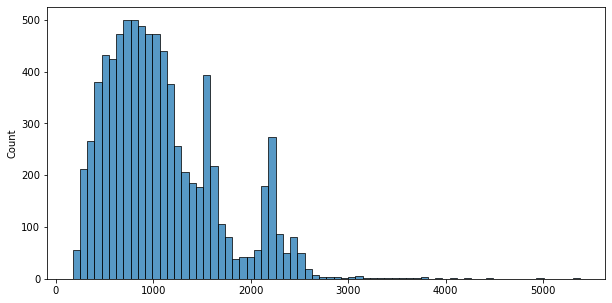

In [177]:
sns.histplot(df_gff_cat_ch['end'] - df_gff_cat_ch['start'])

In [176]:

df_gff_cat_ch['start'] = df_gff_cat_ch['start'] - 50
df_gff_cat_ch['end'] = df_gff_cat_ch['end'] + 50
df_gff_cat_ch

,seqid,source,type,start,end,score,strand,phase,attributes,site,id
672,contig_10014,eggNOG-mapper,CDS,417889,419036,694.0,+,.,ID=contig_10014_255;em_target=717785.HYPMC_155...,C1,C1_contig_10014_255
2815,contig_10071,eggNOG-mapper,CDS,78570,79711,540.0,-,.,ID=contig_10071_106;em_target=1005994.GTGU_045...,C1,C1_contig_10071_106
12680,contig_1031,eggNOG-mapper,CDS,22080,24324,1221.0,-,.,ID=contig_1031_0;em_target=1114964.L485_11740;...,C1,C1_contig_1031_0
12755,contig_10321,eggNOG-mapper,CDS,1617,2346,317.0,-,.,ID=contig_10321_22;em_target=365046.Rta_35780;...,C1,C1_contig_10321_22
12758,contig_10321,eggNOG-mapper,CDS,4211,4961,323.0,-,.,ID=contig_10321_21;em_target=365046.Rta_35810;...,C1,C1_contig_10321_21
...,...,...,...,...,...,...,...,...,...,...,...
7214168,contig_98432,eggNOG-mapper,CDS,12399,13935,776.0,+,.,ID=contig_98432_2;em_target=1385515.N791_11315...,L3,L3_contig_98432_2
7227235,contig_99083,eggNOG-mapper,CDS,9914,10204,104.0,+,.,ID=contig_99083_20;em_target=1403313.AXBR01000...,L3,L3_contig_99083_20
7227236,contig_99083,eggNOG-mapper,CDS,10115,10550,189.0,+,.,ID=contig_99083_13;em_target=414684.RC1_2172;e...,L3,L3_contig_99083_13
7233994,contig_99452,eggNOG-mapper,CDS,42028,44192,996.0,-,.,ID=contig_99452_0;em_target=1120983.KB894576_g...,L3,L3_contig_99452_0


In [ ]:
df_gff_

In [168]:
df_gff_cat_ch

,seqid,source,type,start,end,score,strand,phase,attributes,site,id
672,contig_10014,eggNOG-mapper,CDS,417939,418986,694.0,+,.,ID=contig_10014_255;em_target=717785.HYPMC_155...,C1,C1_contig_10014_255
2815,contig_10071,eggNOG-mapper,CDS,78620,79661,540.0,-,.,ID=contig_10071_106;em_target=1005994.GTGU_045...,C1,C1_contig_10071_106
12680,contig_1031,eggNOG-mapper,CDS,22130,24274,1221.0,-,.,ID=contig_1031_0;em_target=1114964.L485_11740;...,C1,C1_contig_1031_0
12755,contig_10321,eggNOG-mapper,CDS,1667,2296,317.0,-,.,ID=contig_10321_22;em_target=365046.Rta_35780;...,C1,C1_contig_10321_22
12758,contig_10321,eggNOG-mapper,CDS,4261,4911,323.0,-,.,ID=contig_10321_21;em_target=365046.Rta_35810;...,C1,C1_contig_10321_21
...,...,...,...,...,...,...,...,...,...,...,...
7214168,contig_98432,eggNOG-mapper,CDS,12449,13885,776.0,+,.,ID=contig_98432_2;em_target=1385515.N791_11315...,L3,L3_contig_98432_2
7227235,contig_99083,eggNOG-mapper,CDS,9964,10154,104.0,+,.,ID=contig_99083_20;em_target=1403313.AXBR01000...,L3,L3_contig_99083_20
7227236,contig_99083,eggNOG-mapper,CDS,10165,10500,189.0,+,.,ID=contig_99083_13;em_target=414684.RC1_2172;e...,L3,L3_contig_99083_13
7233994,contig_99452,eggNOG-mapper,CDS,42078,44142,996.0,-,.,ID=contig_99452_0;em_target=1120983.KB894576_g...,L3,L3_contig_99452_0


In [41]:
df[df["seed_ortholog"].str.contains("AfiDRAFT_1589", na=False)]

,#query,seed_ortholog,evalue,score,eggNOG_OGs,max_annot_lvl,COG_category,Description,Preferred_name,GOs,...,KEGG_Pathway,KEGG_Module,KEGG_Reaction,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG_Reaction,PFAMs,site
1004059,contig_69705_1,666684.AfiDRAFT_1589,0.000000e+00,1083.0,"COG0443@1|root,COG0443@2|Bacteria,1MVEN@1224|P...",28211|Alphaproteobacteria,O,Heat shock 70 kDa protein,dnaK,NaN,...,"ko03018,ko04212,ko05152,map03018,map04212,map0...",NaN,NaN,NaN,"ko00000,ko00001,ko03019,ko03029,ko03110,ko04147",1.A.33.1,NaN,NaN,HSP70,C1
1170178,contig_10001:1.0-29871.0_22,666684.AfiDRAFT_1589,6.600000e-53,211.0,"COG0443@1|root,COG0443@2|Bacteria,1MVEN@1224|P...",28211|Alphaproteobacteria,O,Heat shock 70 kDa protein,dnaK,NaN,...,"ko03018,ko04212,ko05152,map03018,map04212,map0...",NaN,NaN,NaN,"ko00000,ko00001,ko03019,ko03029,ko03110,ko04147",1.A.33.1,NaN,NaN,HSP70,C2
1170493,contig_10010:1.0-176242.0_4,666684.AfiDRAFT_1589,0.000000e+00,1107.0,"COG0443@1|root,COG0443@2|Bacteria,1MVEN@1224|P...",28211|Alphaproteobacteria,O,Heat shock 70 kDa protein,dnaK,NaN,...,"ko03018,ko04212,ko05152,map03018,map04212,map0...",NaN,NaN,NaN,"ko00000,ko00001,ko03019,ko03029,ko03110,ko04147",1.A.33.1,NaN,NaN,HSP70,C2
2415277,contig_9998:1.0-5353.0_4,666684.AfiDRAFT_1589,7.230000e-32,143.0,"COG0443@1|root,COG0443@2|Bacteria,1MVEN@1224|P...",28211|Alphaproteobacteria,O,Heat shock 70 kDa protein,dnaK,NaN,...,"ko03018,ko04212,ko05152,map03018,map04212,map0...",NaN,NaN,NaN,"ko00000,ko00001,ko03019,ko03029,ko03110,ko04147",1.A.33.1,NaN,NaN,HSP70,C2
3247847,contig_4182_74,666684.AfiDRAFT_1589,2.170000e-26,131.0,"COG0443@1|root,COG0443@2|Bacteria,1MVEN@1224|P...",28211|Alphaproteobacteria,O,Heat shock 70 kDa protein,dnaK,NaN,...,"ko03018,ko04212,ko05152,map03018,map04212,map0...",NaN,NaN,NaN,"ko00000,ko00001,ko03019,ko03029,ko03110,ko04147",1.A.33.1,NaN,NaN,HSP70,C3
4048753,contig_46471_0,666684.AfiDRAFT_1589,4.730000e-205,649.0,"COG0443@1|root,COG0443@2|Bacteria,1MVEN@1224|P...",28211|Alphaproteobacteria,O,Heat shock 70 kDa protein,dnaK,NaN,...,"ko03018,ko04212,ko05152,map03018,map04212,map0...",NaN,NaN,NaN,"ko00000,ko00001,ko03019,ko03029,ko03110,ko04147",1.A.33.1,NaN,NaN,HSP70,L1
4693271,contig_1978_33,666684.AfiDRAFT_1589,0.000000e+00,1214.0,"COG0443@1|root,COG0443@2|Bacteria,1MVEN@1224|P...",28211|Alphaproteobacteria,O,Heat shock 70 kDa protein,dnaK,NaN,...,"ko03018,ko04212,ko05152,map03018,map04212,map0...",NaN,NaN,NaN,"ko00000,ko00001,ko03019,ko03029,ko03110,ko04147",1.A.33.1,NaN,NaN,HSP70,L2
4721092,contig_20919_0,666684.AfiDRAFT_1589,2.530000e-200,597.0,"COG0443@1|root,COG0443@2|Bacteria,1MVEN@1224|P...",28211|Alphaproteobacteria,O,Heat shock 70 kDa protein,dnaK,NaN,...,"ko03018,ko04212,ko05152,map03018,map04212,map0...",NaN,NaN,NaN,"ko00000,ko00001,ko03019,ko03029,ko03110,ko04147",1.A.33.1,NaN,NaN,HSP70,L2
4880703,contig_3073_75,666684.AfiDRAFT_1589,2.940000e-53,213.0,"COG0443@1|root,COG0443@2|Bacteria,1MVEN@1224|P...",28211|Alphaproteobacteria,O,Heat shock 70 kDa protein,dnaK,NaN,...,"ko03018,ko04212,ko05152,map03018,map04212,map0...",NaN,NaN,NaN,"ko00000,ko00001,ko03019,ko03029,ko03110,ko04147",1.A.33.1,NaN,NaN,HSP70,L2
4881318,contig_3078_16,666684.AfiDRAFT_1589,3.000000e-47,193.0,"COG0443@1|root,COG0443@2|Bacteria,1MVEN@1224|P...",28211|Alphaproteobacteria,O,Heat shock 70 kDa protein,dnaK,NaN,...,"ko03018,ko04212,ko05152,map03018,map04212,map0...",NaN,NaN,NaN,"ko00000,ko00001,ko03019,ko03029,ko03110,ko04147",1.A.33.1,NaN,NaN,HSP70,L2


## bedtools -- env metabat

In [27]:
!head -n 3 anno/C2.emapper.genepred.gff

##gff-version 3
## created with emapper-2.1.9
contig_10001:1.0-29871.0	eggNOG-mapper	CDS	1	495	211.0	-	.	ID=contig_10001:1.0-29871.0_22;em_target=666684.AfiDRAFT_1589;em_score=211.0;em_evalue=6.6e-53;em_tcov=21.0;em_searcher=diamond


In [46]:
!grep "contig_10001:1.0-29871.0_28" anno/C2.emapper.genepred.gff

contig_10001:1.0-29871.0	eggNOG-mapper	CDS	29744	29904	64.7	+	.	ID=contig_10001:1.0-29871.0_28;em_target=709797.CSIRO_1031;em_score=64.7;em_evalue=5.48e-07;em_tcov=16.7;em_searcher=diamond


In [50]:
29904 - 29744

160

In [52]:
!grep -B 2 "contig_10001:1.0-29871.0_28" anno/C2.emapper.genepred.fasta

>contig_10001:1.0-29871.0_23
GCTGGCGCAATCGCCGACGGCGGGCCGCACAGCTTCTCGGCCAGTTCGGAGATTGGGGCGCCTATACGGCCCGCCCGGCGGCAAGAAAATCTGCTTCGCCCTGGCCAAGCCAGCCACGTCCGAGACCAATCCGCCCAATCGCCCGCGTGATCCAGCCTGGTTCTTTGTGTCCACCCGGCCTGCCGAAAGGTGAAGGAAGAGGTTTCGGTCATCATCGGCTATCGTTCAAGGCGAACAGCGATGCCGTGGTCGAGATCGGCAGCACCAATTTGCCATGTACACGCAGAATGACGGCGCGTGGGTGAAGAACGCCGCCGAGGAAGCCCGGCTGATCGAGGCCATGCGGCGCGGCGCCGATGTAACGGTGCGGGGCAGATCGGCCGCGGCACCAAGACGACCGACCGCTTTTCGCTGAAGGGCGTTGCCCAGGCGCTCGACCGCGCCGCGCAGGAATGCCGG
>contig_10001:1.0-29871.0_28


In [49]:
!grep "contig_10001:1.0-29871.0" ../rnf_c/fastas/C2.fasta

>contig_10001:1.0-29871.0


In [1010]:
keggRest("1.11.1.6")

ORTHOLOGY   K03781  catalase
            K19885  dichlorochromopyrrolate synthase / catalase


In [926]:
keggRest("ko:K07217 ", ["NAME", "PATHWAY", "DBLINKS"])

NAME        Mn-containing catalase
DBLINKS     COG: COG3546


In [974]:
rq = requests.get("https://rest.uniprot.org/uniprotkb/search?query=xref:eggno-:COG3546?format=json")

In [973]:
rq.text

'{"url":"http://rest.uniprot.org/uniprotkb/search","messages":["query parameter has an invalid syntax"]}'

In [993]:
rq = requests.get("https://rest.uniprot.org/uniprotkb/search?query=xref:eggnog-COG3546&format=json")
search_res = rq.json()

In [1006]:
for i in search_res['results']:
    print(i.keys())
    break

dict_keys(['entryType', 'primaryAccession', 'uniProtkbId', 'entryAudit', 'annotationScore', 'organism', 'proteinExistence', 'proteinDescription', 'genes', 'comments', 'features', 'keywords', 'references', 'uniProtKBCrossReferences', 'sequence', 'extraAttributes'])


In [1008]:
for i in search_res['results']:
    print(i["proteinDescription"])


{'recommendedName': {'fullName': {'value': 'Protein CotJC'}}}
{'recommendedName': {'fullName': {'value': 'Probable manganese catalase'}, 'ecNumbers': [{'value': '1.11.1.6'}]}, 'alternativeNames': [{'fullName': {'value': 'General stress protein 80'}, 'shortNames': [{'value': 'GSP80'}]}]}
{'recommendedName': {'fullName': {'value': 'Probable manganese catalase'}, 'ecNumbers': [{'value': '1.11.1.6'}]}}
{'recommendedName': {'fullName': {'value': 'Uncharacterized protein YjqC'}}}
{'submissionNames': [{'fullName': {'evidences': [{'evidenceCode': 'ECO:0000313', 'source': 'EMBL', 'id': 'EFP61762.1'}], 'value': 'Uncharacterized protein'}}]}
{'submissionNames': [{'fullName': {'evidences': [{'evidenceCode': 'ECO:0000313', 'source': 'EMBL', 'id': 'OXC75705.1'}], 'value': 'Uncharacterized protein'}}]}
{'submissionNames': [{'fullName': {'evidences': [{'evidenceCode': 'ECO:0000313', 'source': 'EMBL', 'id': 'CCV05657.1'}], 'value': 'Manganese containing catalase'}}]}
{'submissionNames': [{'fullName': {

In [923]:
keggRest("ko:K03781 ", ["NAME", "PATHWAY"])

NAME        catalase [EC:1.11.1.6]
PATHWAY     map00380  Tryptophan metabolism
            map00630  Glyoxylate and dicarboxylate metabolism
            map01100  Metabolic pathways
            map01110  Biosynthesis of secondary metabolites
            map01200  Carbon metabolism
            map04011  MAPK signaling pathway - yeast
            map04016  MAPK signaling pathway - plant
            map04068  FoxO signaling pathway
            map04146  Peroxisome
            map04211  Longevity regulating pathway
            map04212  Longevity regulating pathway - worm
            map04213  Longevity regulating pathway - multiple species
            map05014  Amyotrophic lateral sclerosis
            map05022  Pathways of neurodegeneration - multiple diseases
            map05208  Chemical carcinogenesis - reactive oxygen species


In [207]:
df.head(100).groupby("eggNOG_OGs").count()["#query"].sort_values(ascending=True)

eggNOG_OGs
28HJP@1|root,2Z7UT@2|Bacteria,1MWM4@1224|Proteobacteria,1RQNG@1236|Gammaproteobacteria,1Y5H3@135624|Aeromonadales                       1
COG2207@1|root,COG2207@2|Bacteria,1RJPK@1224|Proteobacteria,2TVEN@28211|Alphaproteobacteria,2K6A9@204457|Sphingomonadales               1
COG2197@1|root,COG2197@2|Bacteria,1MWGM@1224|Proteobacteria,2U0JP@28211|Alphaproteobacteria,2K2JD@204457|Sphingomonadales               1
COG2173@1|root,COG2173@2|Bacteria,1RENK@1224|Proteobacteria,1S3SJ@1236|Gammaproteobacteria,1X64M@135614|Xanthomonadales                 1
COG2128@1|root,COG2128@2|Bacteria,1RAS1@1224|Proteobacteria,1S2WN@1236|Gammaproteobacteria,1YIKW@136841|Pseudomonas aeruginosa group    1
                                                                                                                                       ..
COG0791@1|root,COG0791@2|Bacteria,1R45H@1224|Proteobacteria,1RZDR@1236|Gammaproteobacteria,1X5RQ@135614|Xanthomonadales                 1
COG0702@1|root,COG0702@

In [213]:
df.head(100)["COG_category"].isnull()

0     False
1     False
2     False
3     False
4     False
      ...  
95    False
96    False
97    False
98    False
99    False
Name: COG_category, Length: 100, dtype: bool

In [241]:
df.head(10)["eggNOG_OGs"].to_list()[1].split(",")[0].split("@")[0]

'COG1435'

In [232]:
df.head(1000).loc[df.head(1000)["COG_category"].isnull()]["eggNOG_OGs"].to_list()[1].split(",")[0].split("@")[0]

'29XXR'

In [ ]:
requests.get("http://eggnogapi5.embl.de/nog_data/json/tree,go_terms,domains/COG1435").json()

In [ ]:
r.json()

In [915]:
def keggRest(what, entry ="ORTHOLOGY"):
    HELP = ['ENTRY', 'NAME', 'CLASS', 'SYSNAME', 'REACTION', 'ALL_REAC', 'SUBSTRATE', 'PRODUCT', 'COMMENT', 'HISTORY', 'REFERENCE','PATHWAY', 'ORTHOLOGY', 'GENES', 'DBLINKS']
    if what.lower() == "help":
        print(HELP)
        return
    entry_l = []
    if isinstance(entry, str):
        entry_l.append(entry)
    if isinstance(entry, type([])):
        entry_l.extend(entry)      
    kr = requests.get(f"https://rest.kegg.jp/get/{what}")
    if kr.status_code != 200:
        print(f"ERROR {kr.status_code}")
        return
    l = kr.text.split("\n")
    res = [i[0] for i in enumerate(l) if i[1].startswith(tuple(entry_l))]
    for a in res:
        for num, line in [i for i in enumerate(l)][a:]:
            if num >= a:
                if (not num == a) and not line.startswith(" "):
                    break
                else:
                    print(line)

In [881]:
kr.status_code

200

In [913]:
keggRest("1.11.1.6", ["ORTHOLOGY", "ENTRY", "DBLINKS", "NAME"])

ENTRY       EC 1.11.1.6                 Enzyme
NAME        catalase;
            equilase;
            caperase;
            optidase;
            catalase-peroxidase;
            CAT
ORTHOLOGY   K03781  catalase
            K19885  dichlorochromopyrrolate synthase / catalase
DBLINKS     ExplorEnz - The Enzyme Database: 1.11.1.6
            IUBMB Enzyme Nomenclature: 1.11.1.6
            ExPASy - ENZYME nomenclature database: 1.11.1.6
            UM-BBD (Biocatalysis/Biodegradation Database): 1.11.1.6
            BRENDA, the Enzyme Database: 1.11.1.6
            CAS: 9001-05-2


In [914]:
keggRest("help")

['ENTRY', 'NAME', 'CLASS', 'SYSNAME', 'REACTION', 'ALL_REAC', 'SUBSTRATE', 'PRODUCT', 'COMMENT', 'HISTORY', 'REFERENCE', 'PATHWAY', 'ORTHOLOGY', 'GENES', 'DBLINKS']


In [380]:
keggRest("1.11.1.6")

['ORTHOLOGY   K03781  catalase',
 '            K19885  dichlorochromopyrrolate synthase / catalase']

In [ ]:
kr.

In [273]:
!ls

anno
